In [13]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import VFDstuff as VFD
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from copy import copy as cp
import matplotlib.path as mpltPath

In [14]:
%matplotlib notebook
fontsize = 25
color = 'k'
linewidth = 4
markersize = 10

# Units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
angle_unit = 'radian'

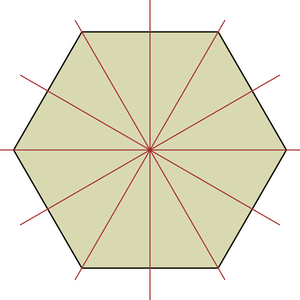

In [15]:
# Defining properties of the crystal and the box it's in

# Some key parameters
L = AssignQuantity(30,distance_unit)
npts_theta = 10
npts_r = 75
r_far_field = L*3.5

<IPython.core.display.Javascript object>


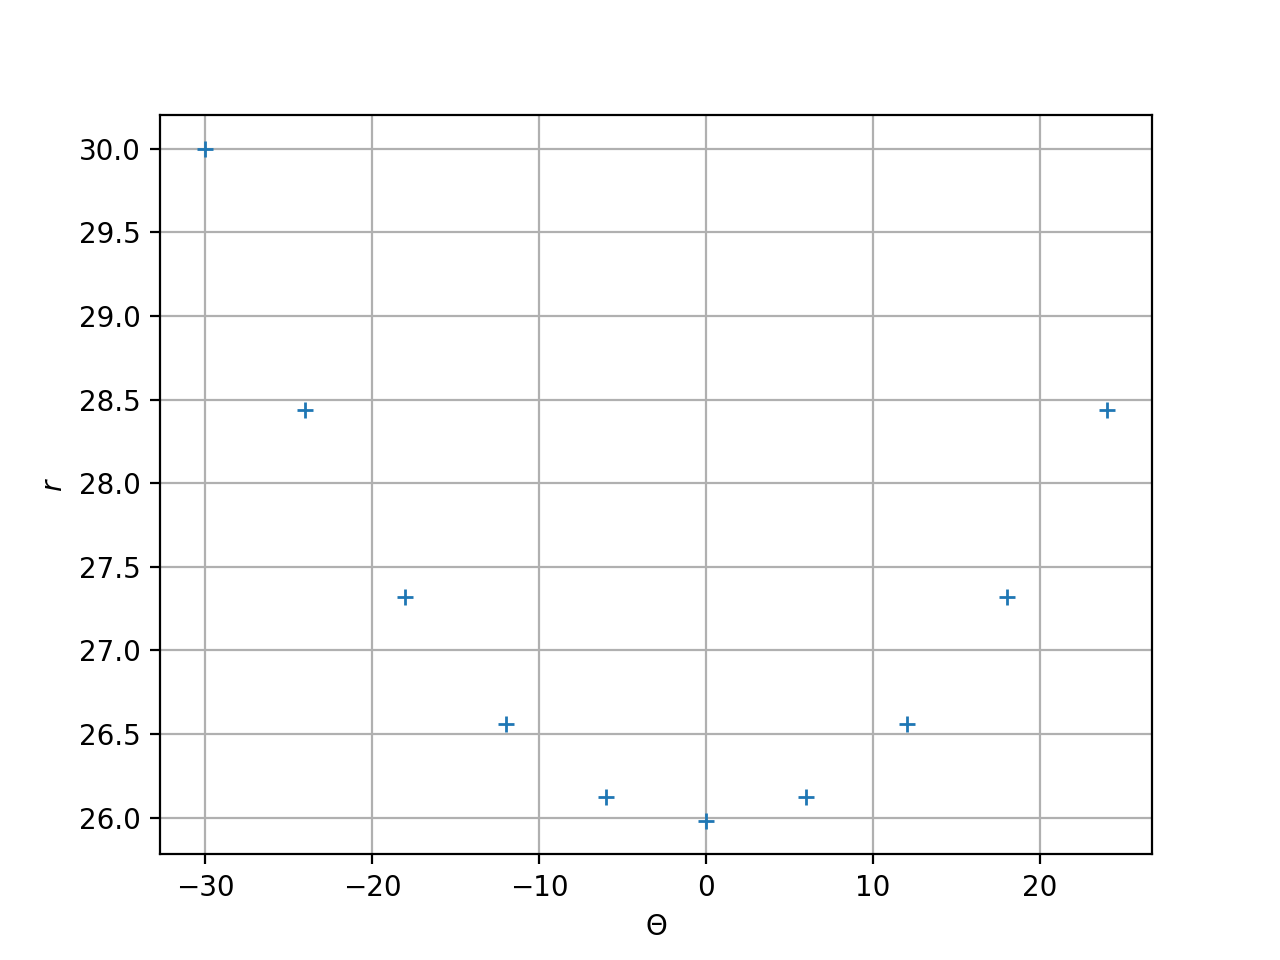

<IPython.core.display.Javascript object>


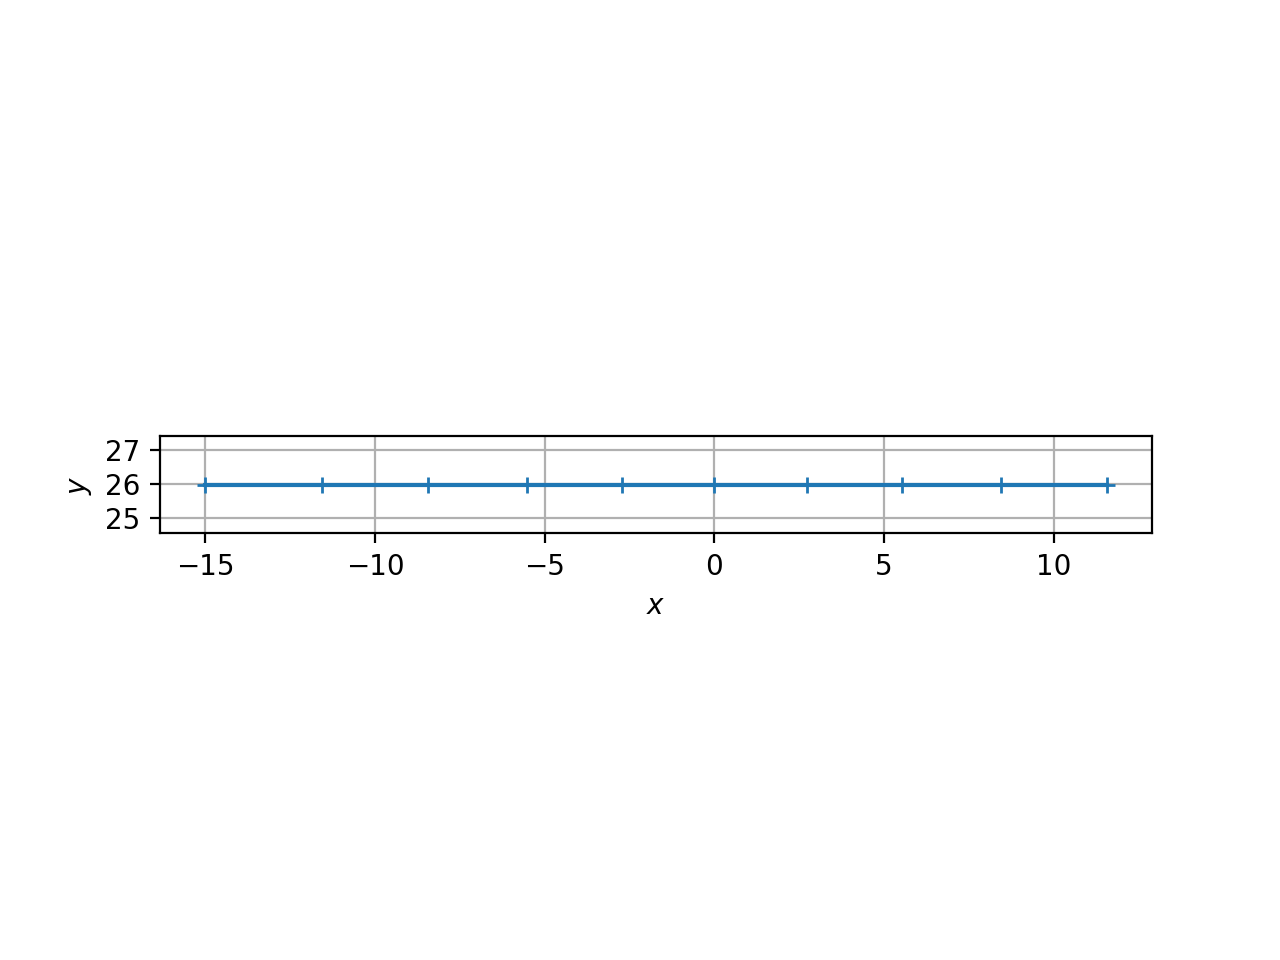

<IPython.core.display.Javascript object>


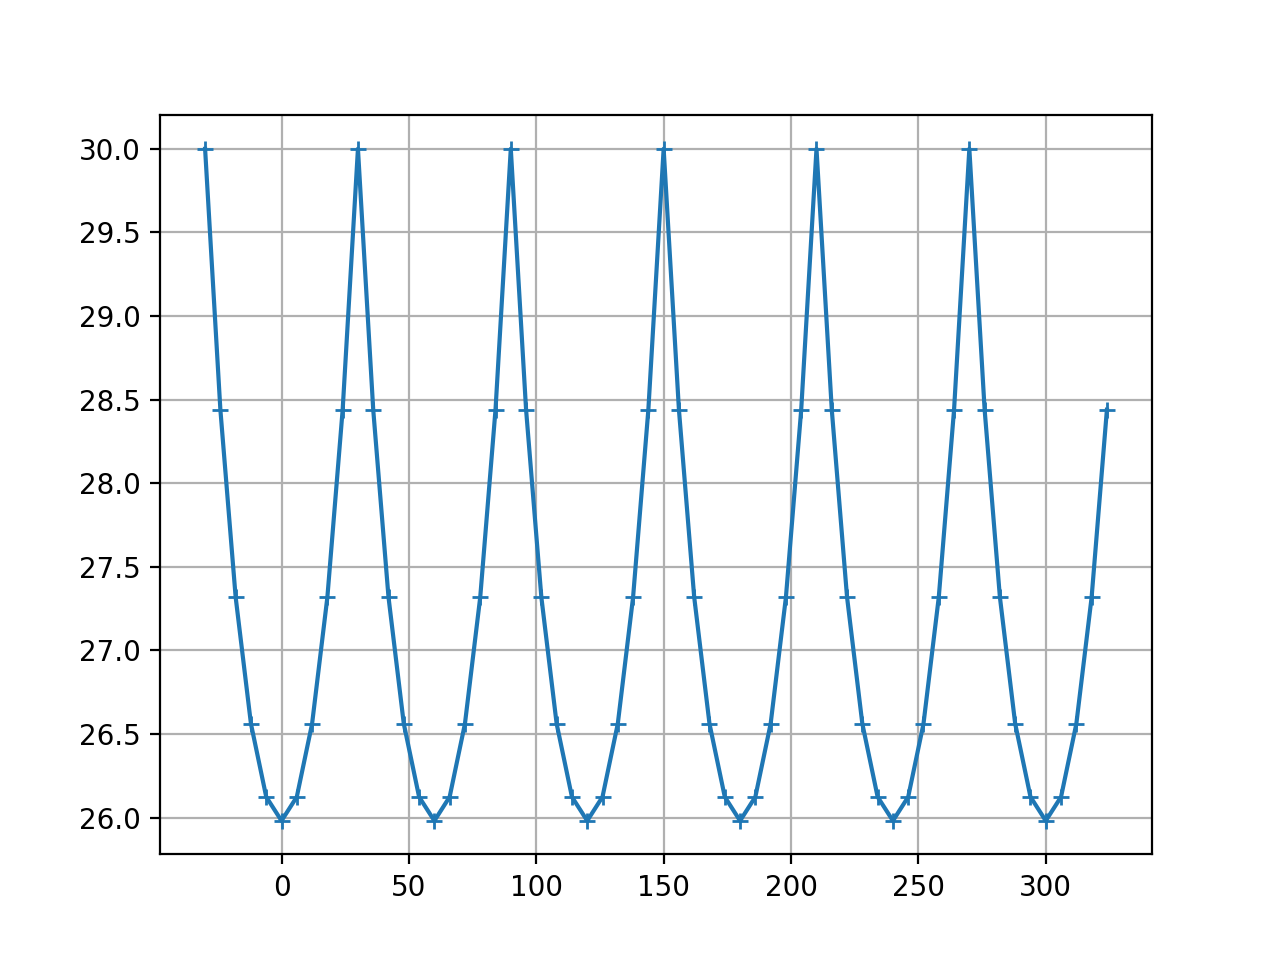

(60,)
(60,)


In [16]:
# Making the crystal

# Make the top edge of the crystal
angle = AssignQuantity(30, 'degree')
angle.ito(angle_unit)
y0 =L*np.cos(angle)
edge0_theta_complete = np.linspace(-angle,angle,npts_theta+1)
edge0_theta = edge0_theta_complete[0:-1]
dtheta = edge0_theta[1]-edge0_theta[0]
edge0_r = y0/np.cos(edge0_theta)
fig, ax = plt.subplots()
plt.plot(edge0_theta.to('degree'),edge0_r,'+')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')
plt.grid(True)

# Convert to Cartesian to make sure this is a straight line at the right place
edge0_x = edge0_r*np.sin(edge0_theta)
edge0_y = edge0_r*np.cos(edge0_theta)
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edge0_x,edge0_y,'+-')
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)

# Gather all the edges together as one big array
edges_theta = np.hstack([\
        edge0_theta,
        edge0_theta+2*angle,
        edge0_theta+4*angle,
        edge0_theta+6*angle,
        edge0_theta+8*angle,
        edge0_theta+10*angle])
edges_r = np.hstack([\
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r])
edges_r = AssignQuantity(edges_r,distance_unit)
edges_theta = AssignQuantity(edges_theta,angle_unit)
fig, ax = plt.subplots()
print(np.shape(edges_theta.to('degree').magnitude))
print(np.shape(edges_r.magnitude))
plt.plot(edges_theta.to('degree').magnitude,edges_r.magnitude,'+-')
plt.grid(True)

25.98076211353316 micrometer
105.0 micrometer
dr = 1.0678275390063092 micrometer
r-values:  [ 25.98076211  27.04858965  28.11641719  29.18424473  30.25207227
  31.31989981  32.38772735  33.45555489  34.52338243  35.59120996
  36.6590375   37.72686504  38.79469258  39.86252012  40.93034766
  41.9981752   43.06600274  44.13383028  45.20165782  46.26948535
  47.33731289  48.40514043  49.47296797  50.54079551  51.60862305
  52.67645059  53.74427813  54.81210567  55.87993321  56.94776074
  58.01558828  59.08341582  60.15124336  61.2190709   62.28689844
  63.35472598  64.42255352  65.49038106  66.5582086   67.62603613
  68.69386367  69.76169121  70.82951875  71.89734629  72.96517383
  74.03300137  75.10082891  76.16865645  77.23648399  78.30431152
  79.37213906  80.4399666   81.50779414  82.57562168  83.64344922
  84.71127676  85.7791043   86.84693184  87.91475938  88.98258691
  90.05041445  91.11824199  92.18606953  93.25389707  94.32172461
  95.38955215  96.45737969  97.52520723  98.593034

<IPython.core.display.Javascript object>


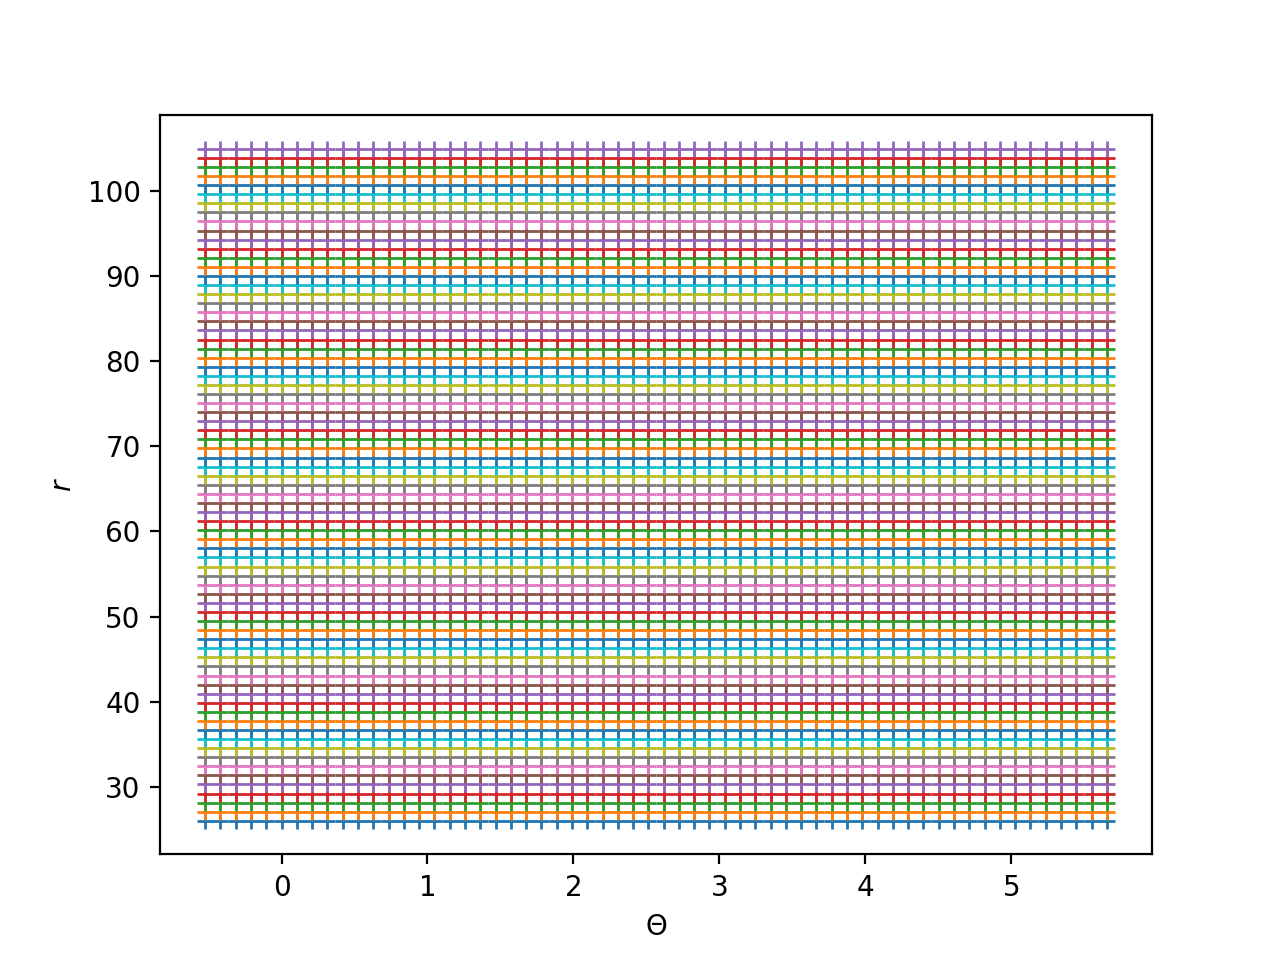

<IPython.core.display.Javascript object>


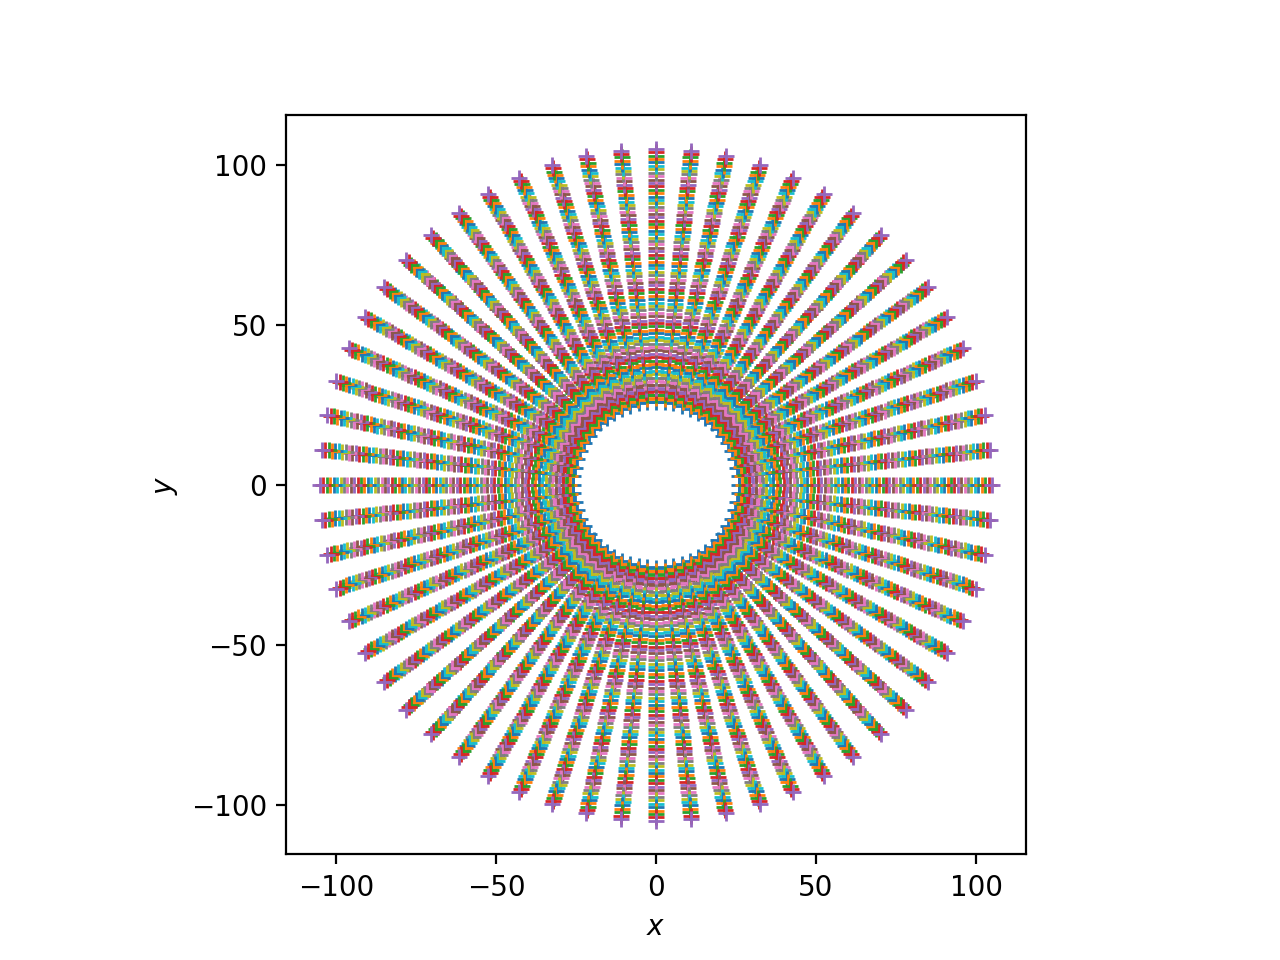

Text(0, 0.5, '$y$')

In [17]:
# Making a discretized box to put the crystal into (we'll use the crystal's angles)
rmin = np.min(edges_r); print(rmin)
rmax = r_far_field; print(rmax)
array_r = np.linspace(rmin,rmax,npts_r)
dr = array_r[1]-array_r[0]; print('dr =', dr)
array_theta = edges_theta
grid_r, grid_theta = np.meshgrid(array_r.magnitude,array_theta.magnitude)
print('r-values: ', grid_r[0,:])
print('theta-valeus = ', grid_theta[:,0]*180/np.pi)
plt.figure()
plt.plot(grid_theta,grid_r,'+')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')

# Converting to Cartesian to see what this looks like
grid_x = array_r*np.sin(grid_theta)
grid_y = array_r*np.cos(grid_theta)
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(grid_x.magnitude,grid_y.magnitude,'+')
plt.xlabel('$x$')
plt.ylabel('$y$')

In [18]:
# Physical parameters

# Setting ice parameters
sigma0 = 0.2
print('sigma0 = ',sigma0)

# The far-field supersaturation
sigmaI_far_field = 0.3

# Temperature and pressure
Temp = AssignQuantity(240,'kelvin')
Pressure = AssignQuantity(50,'pascal')

# Converting to the desired pressure unit
Pressure.ito(pressure_unit)
print('Pressure = ', Pressure)
print('Temperature = ',Temp)

# Checking on the plausibility of this growth rate
nu_kin = VFD.get_nu_kin(Temp,AssignQuantity)
print('g_ice should be smaller than sigmaI_far_field x nu_kin ...')
print('nu_kin = ', nu_kin)
print('sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)

# Compute diffusion coefficient of water through air at this temperature
# This is using trends from engineering toolbox, with the log-log correction
D = VFD.getDofTP(Temp,Pressure,AssignQuantity); print('D = ', D)

# Growth rate
g_ice = AssignQuantity(2,'micrometer/second')

# Calculating the Neumann condition at the vapor/ice boundary (starting with ice density)
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')

sigma0 =  0.2
Pressure =  50 pascal
Temperature =  240 kelvin
g_ice should be smaller than sigmaI_far_field x nu_kin ...
nu_kin =  39.341788071548116 micrometer / second
sigmaI_far_field x nu_kin =  11.802536421464435 micrometer / second
D0 =  21.893732126411837
D =  34908.31943863489 micrometer ** 2 / microsecond


In [19]:
# Time step, boundary conditions, etc.

# Getting a suitable time step
dt = dr**2/D/10; print('dt = ', dt)

# Computing effective diffusion coefficents - which should be dimensionless
Dreff = D*dt/dr**2; print('Dreff = ', Dreff)
Dthetaeff = D*dt/dtheta**2/L**2; print('Dthetaeff = ', Dthetaeff)

# kappa (need to check if this is right)
kappa = rho_ice*g_ice*R*Temp/(Mvap*dr); kappa.ito(pressure_unit+'/'+time_unit)

# Neumann
uneumann = kappa*dt
uneumann_mag = uneumann.magnitude

# Calculating the dirichlet conditions at the far-field boundary
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting this into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Equilibrium vapor pressure at this temperature = ', P_vapor_eq)
udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

# Making dimensionless variables for efficiency
udirichlet_mag = udirichlet.magnitude

dt =  3.266429525674299e-06 microsecond
Dreff =  0.09999999999999999 dimensionless
Dthetaeff =  0.011553205242293352 / radian ** 2
sigmaI_far_field =  0.3
sigmaII_far_field =  0.09999999999999998
Equilibrium vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  38.41530351858555 pascal


In [20]:
def r_to_ir(r,array_r):
    dr = array_r[1]-array_r[0]
    ir = np.rint((r-array_r[0])/dr).astype(int)
    return ir
r_test = AssignQuantity(107, distance_unit)
ir_test = r_to_ir(r_test, array_r)
print(ir_test)

def ir_to_r(ir_test,array_r):
    dr = array_r[1]-array_r[0]
    r = ir_test*dr+array_r[0]
    return r
r_test2 = ir_to_r(ir_test, array_r)
print('r_test2', r_test2)
print('r Differences ... ', r_test2-r_test)


76 dimensionless
r_test2 107.13565507801266 micrometer
r Differences ...  0.13565507801266108 micrometer


In [21]:
def theta_to_itheta(theta, array_theta):
    dtheta = array_theta[1]-array_theta[0]
    itheta = np.rint((theta-array_theta[0])/dtheta).astype(int)
    return itheta
theta_test = AssignQuantity(-32, 'degree')
itheta_test = theta_to_itheta(theta_test.to(angle_unit), array_theta)
print(itheta_test)

def itheta_to_theta(itheta, array_theta):
    dtheta = array_theta[1]-array_theta[0]
    theta = itheta*dtheta+array_theta[0]
    return(theta)
theta_test2 = itheta_to_theta(itheta_test, array_theta)
print('theta_test2', theta_test2)
print('theta Differences ... ', theta_test2-theta_test)

0 dimensionless
theta_test2 -0.5235987755982988 radian
theta Differences ...  0.03490658503988664 radian


### Progress
The cells below are "in progress"

<IPython.core.display.Javascript object>


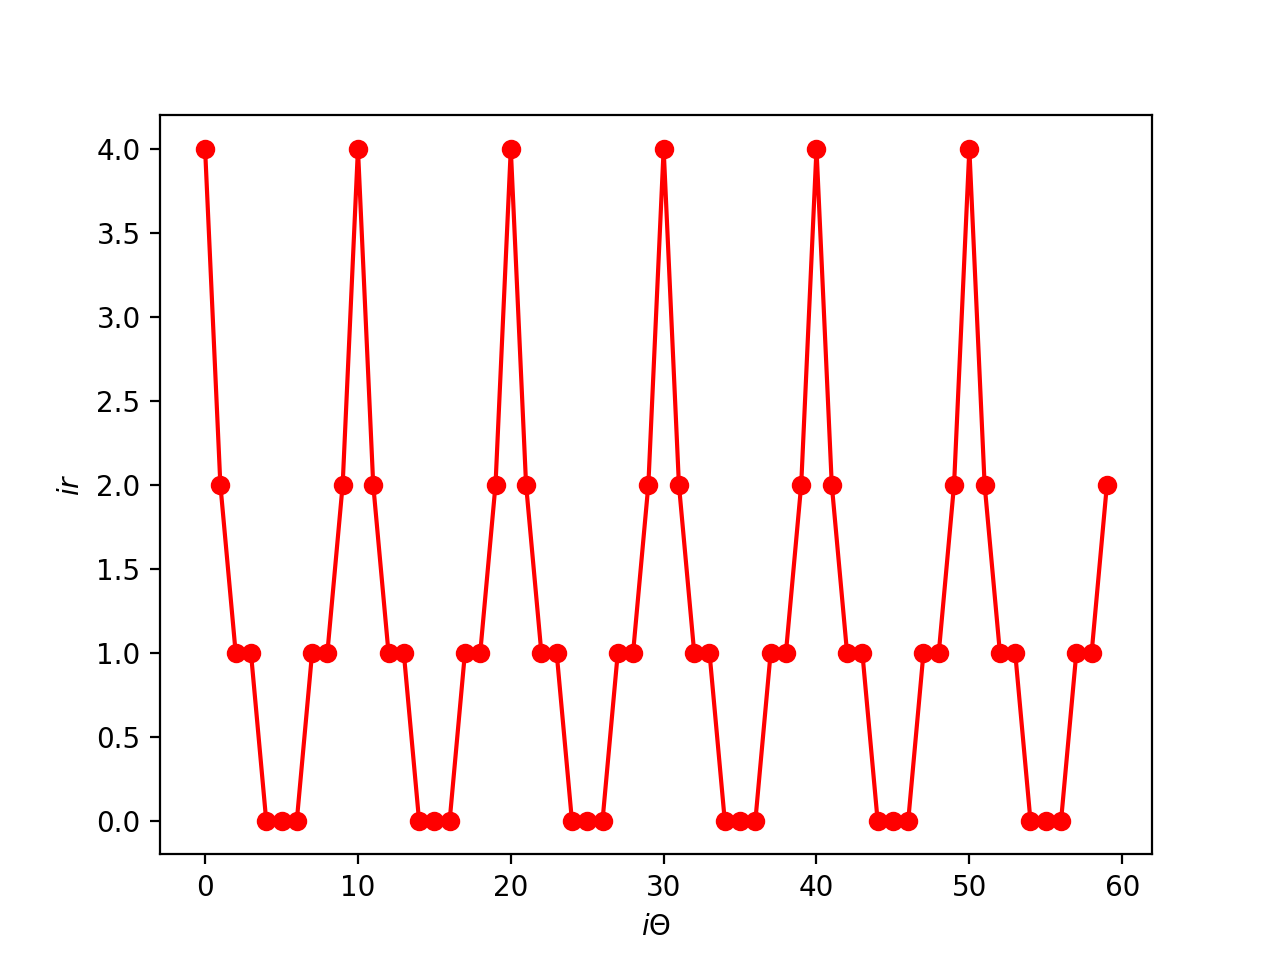

Text(0, 0.5, '$ir$')

In [22]:
edges_ir = r_to_ir(edges_r,array_r)
edges_itheta = theta_to_itheta(edges_theta, array_theta)

plt.figure()
# plt.plot(grid_theta,grid_r,'+b')
plt.plot(edges_itheta,edges_ir,'ro-')
plt.xlabel('$i\Theta$')
plt.ylabel('$ir$')

<IPython.core.display.Javascript object>


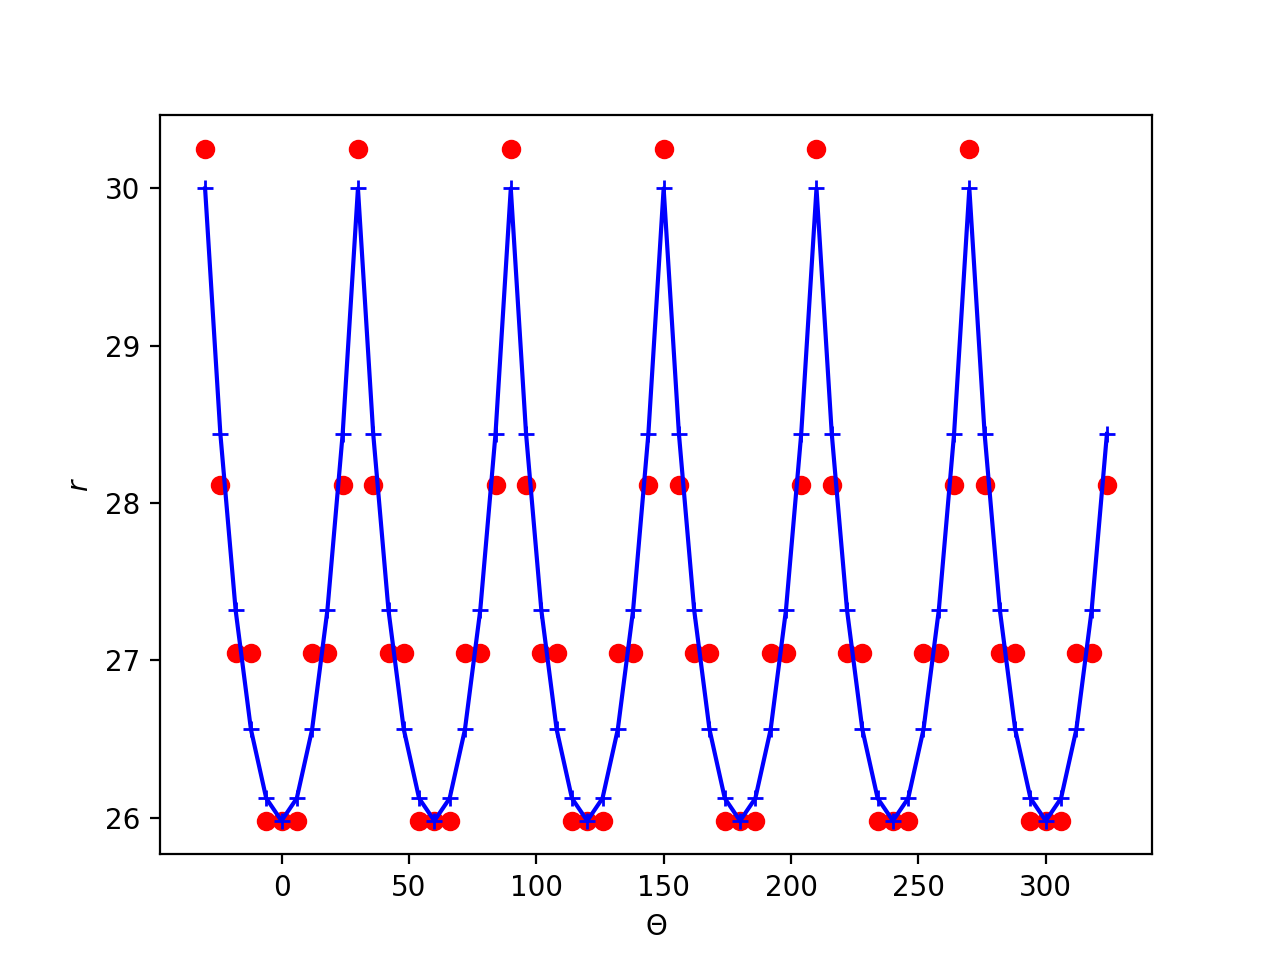

Text(0, 0.5, '$r$')

In [23]:
edges_r2 = ir_to_r(edges_ir, array_r)
edges_theta2 = itheta_to_theta(edges_itheta, array_theta)

plt.figure()
# plt.plot(grid_theta,grid_r,'+b')
plt.plot(edges_theta2.to('degree'),edges_r2,'ro')
plt.plot(edges_theta.to('degree').magnitude,edges_r.magnitude,'b+-')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')

In [44]:
edges = []
for i in range (len(edges_theta)):
    edges.append([edges_theta.to('degree')[i].magnitude, edges_r[i].magnitude])
edges = np.array(edges)
print(edges)

iedges = []
for i in range (len(edges_itheta)):
    iedges.append([edges_itheta[i].magnitude, edges_ir[i].magnitude])
iedges = np.array(iedges)
print('iedges', iedges)

[[-30.          30.        ]
 [-24.          28.43948475]
 [-18.          27.31778992]
 [-12.          26.56118779]
 [ -6.          26.12387141]
 [  0.          25.98076211]
 [  6.          26.12387141]
 [ 12.          26.56118779]
 [ 18.          27.31778992]
 [ 24.          28.43948475]
 [ 30.          30.        ]
 [ 36.          28.43948475]
 [ 42.          27.31778992]
 [ 48.          26.56118779]
 [ 54.          26.12387141]
 [ 60.          25.98076211]
 [ 66.          26.12387141]
 [ 72.          26.56118779]
 [ 78.          27.31778992]
 [ 84.          28.43948475]
 [ 90.          30.        ]
 [ 96.          28.43948475]
 [102.          27.31778992]
 [108.          26.56118779]
 [114.          26.12387141]
 [120.          25.98076211]
 [126.          26.12387141]
 [132.          26.56118779]
 [138.          27.31778992]
 [144.          28.43948475]
 [150.          30.        ]
 [156.          28.43948475]
 [162.          27.31778992]
 [168.          26.56118779]
 [174.        

not keeping (55, 79)
not keeping (56, 79)
not keeping (57, 79)
not keeping (58, 79)
not keeping (59, 79)
not keeping (60, 79)
not keeping (61, 79)
not keeping (62, 79)
not keeping (63, 79)
not keeping (64, 79)
not keeping (65, 79)
not keeping (66, 79)
not keeping (67, 79)
not keeping (68, 79)
not keeping (69, 79)
not keeping (70, 79)
not keeping (71, 79)
not keeping (75, 73)
not keeping (79, 66)


<IPython.core.display.Javascript object>


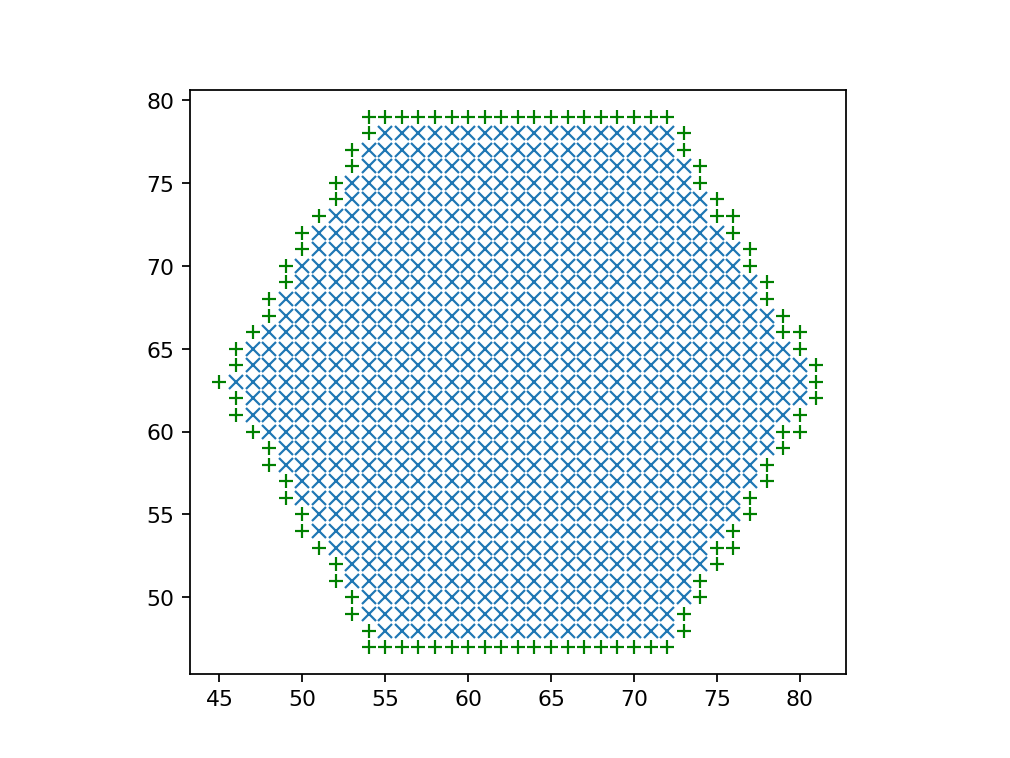

In [9]:
# Getting indices of pixels inside the crystal
iedges_unique_float = iedges_unique.astype(float)
polygon = iedges_unique_float.T
path = mpltPath.Path(polygon); #print(path)
ix_inside = []
iy_inside = []
for ix in range(nx):
    for iy in range(ny):
        inside = path.contains_points([[ix,iy]])
        if inside:
            ix_inside.append(ix)
            iy_inside.append(iy)
i_inside = np.vstack((ix_inside,iy_inside))
i_inside_unique, n_inside_unique = VFD.removedups2(i_inside,iedges_unique)
ix_inside_unique = i_inside_unique[0,:]
iy_inside_unique = i_inside_unique[1,:]
fig, ax = plt.subplots()
ax.set_aspect('equal')
for i in range(npts_unique):
    plt.plot(iedges_unique[0,i],iedges_unique[1,i],'+g')
plt.plot(ix_inside_unique,iy_inside_unique,'x')

<IPython.core.display.Javascript object>


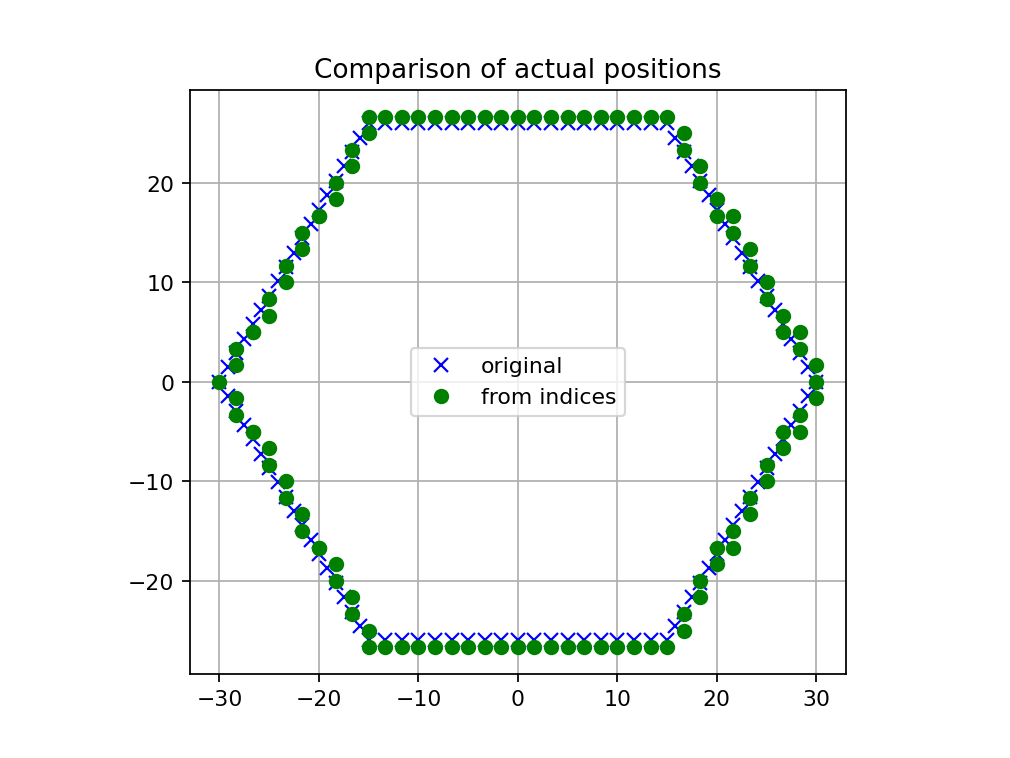

In [10]:
# Checking to make sure the indexed positions are not too far off
xedges_again = VFD.Cartesian_index_to_position(ixedges,Lbox_x,dedge)
yedges_again = VFD.Cartesian_index_to_position(iyedges,Lbox_y,dedge)
edges_again = np.vstack((xedges_again,yedges_again))
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edges[0,:],edges[1,:],'bx',label='original')
plt.plot(edges_again[0,:],edges_again[1,:],'go',label='from indices')
plt.grid(True)
plt.title('Comparison of actual positions')
plt.legend()

127 127


<IPython.core.display.Javascript object>


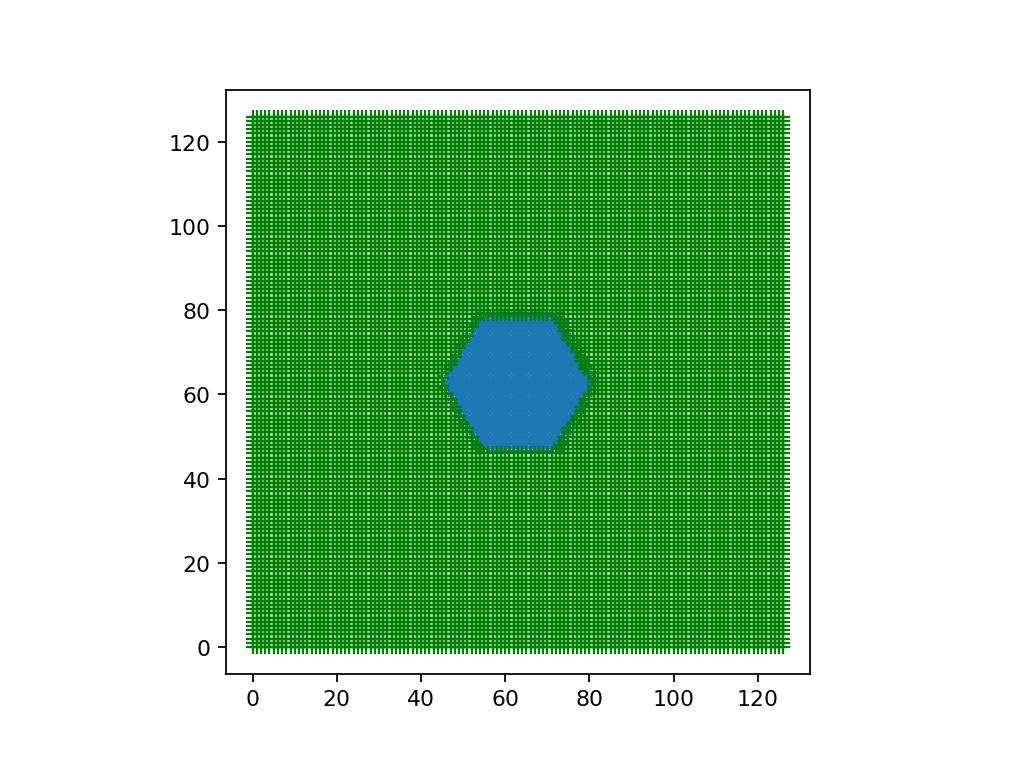

In [11]:
# Calculating the diffusion coefficient matrix, with zeros for in and around the crystal
Dmatrix = np.ones((nx-1,ny-1))*Deff.magnitude
nx_D, ny_D = np.shape(Dmatrix)
print(nx_D, ny_D)
for i in range(n_inside_unique):
    Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]] = 0
    Dmatrix[i_inside_unique[0,i]-1,i_inside_unique[1,i]] = 0
#     Dmatrix[i_inside_unique[0,i]+1,i_inside_unique[1,i]] = 0
    Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]-1] = 0
#     Dmatrix[i_inside_unique[0,i],i_inside_unique[1,i]+1] = 0

# Checking    
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(ix_inside_unique,iy_inside_unique,'x')
for ix in range(nx_D):
    for iy in range(ny_D):
        if Dmatrix[ix,iy] != 0:
            plt.plot(ix,iy,'+g',)

In [12]:
# Calculating the dirichlet conditions at the far-field boundary as supersaturations
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting supersaturations into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Vapor pressure at this temperature = ', P_vapor_eq)
udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

sigmaI_far_field =  0.3
sigmaII_far_field =  0.09999999999999998
Vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  38.41530351858555 pascal


In [13]:
# def propagate_hexagon(u0,udirichlet,uneumann,Deff,Dmatrix,iedges,npts_total):

#     # Propagates the vapor field forward one time step
    
#     # Initialize starting values
#     un = np.zeros(np.shape(u0))

#     # Diffusion throughout (this is wrong)
#     un[1:-1, 1:-1] = u0[1:-1, 1:-1] + ( \
#     ( (u0[2:, 1:-1] - u0[1:-1, 1:-1])*Dmatrix[1:,1:] + (u0[0:-2, 1:-1] -u0[1:-1, 1:-1])*Dmatrix[0:-1,1:] ) + \
#     ( (u0[1:-1, 2:] - u0[1:-1, 1:-1])*Dmatrix[1:,1:] + (u0[1:-1, 0:-2] -u0[1:-1, 1:-1])*Dmatrix[1:,0:-1] ) )
    
#     # Assigning Dirichlet conditions at the perimeter of the simulation box
#     un[[0,-1],:] = udirichlet
#     un[:,[0,-1]] = udirichlet
    
#     # Assigning Neumann conditions above the crystal surface
#     for i in range(npts_total):
#         un[iedges[0,i],iedges[1,i]] -= uneumann
            
#     return(un)

In [14]:
# Decide on a time to propagate forward
tmax = AssignQuantity(1,time_unit)
ntimes = int(tmax/dt)
print('Integrating steps = ', ntimes)
print('Integrating out to ', ntimes*dt) # This is a check -- it should be very close to the tmax specified above

# Propagate forward in time
un = np.zeros(np.shape(xgrid))
for i in range(ntimes):
    un = VFD.Cartesian_propagate_hexagon(\
        un,udirichlet.magnitude,uneumann.magnitude,Deff.magnitude,Dmatrix,\
        iedges, npts_total)

Integrating steps =  62834
Integrating out to  0.9999844833304539 microsecond


63
63
79
47


<IPython.core.display.Javascript object>


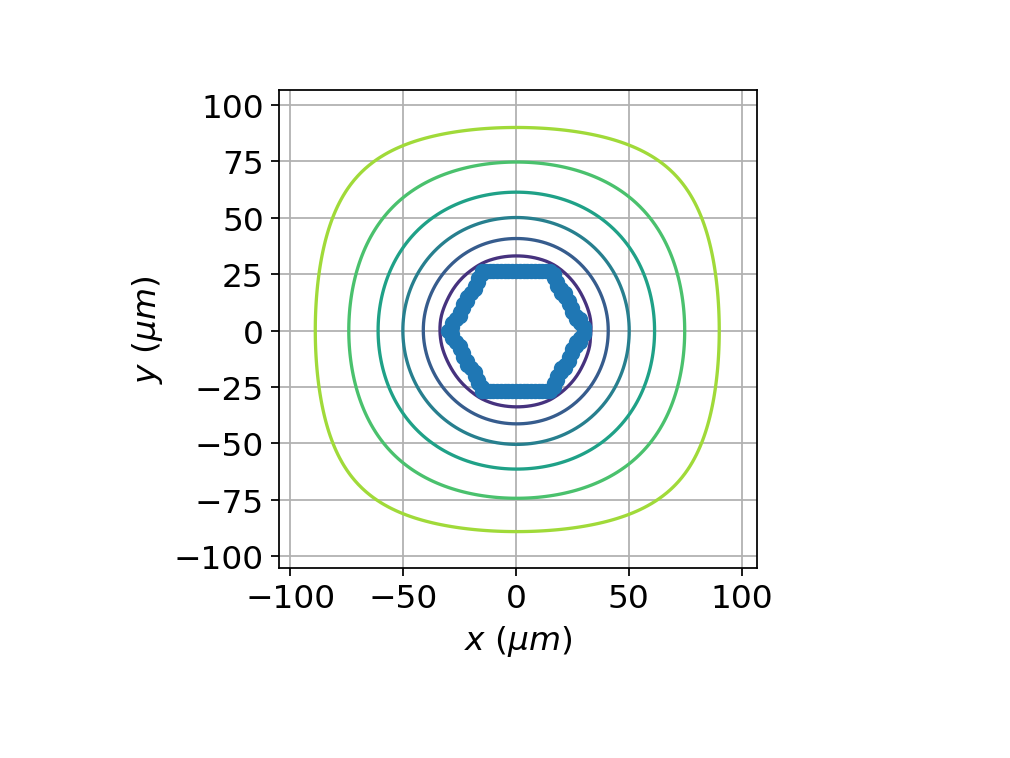

<IPython.core.display.Javascript object>


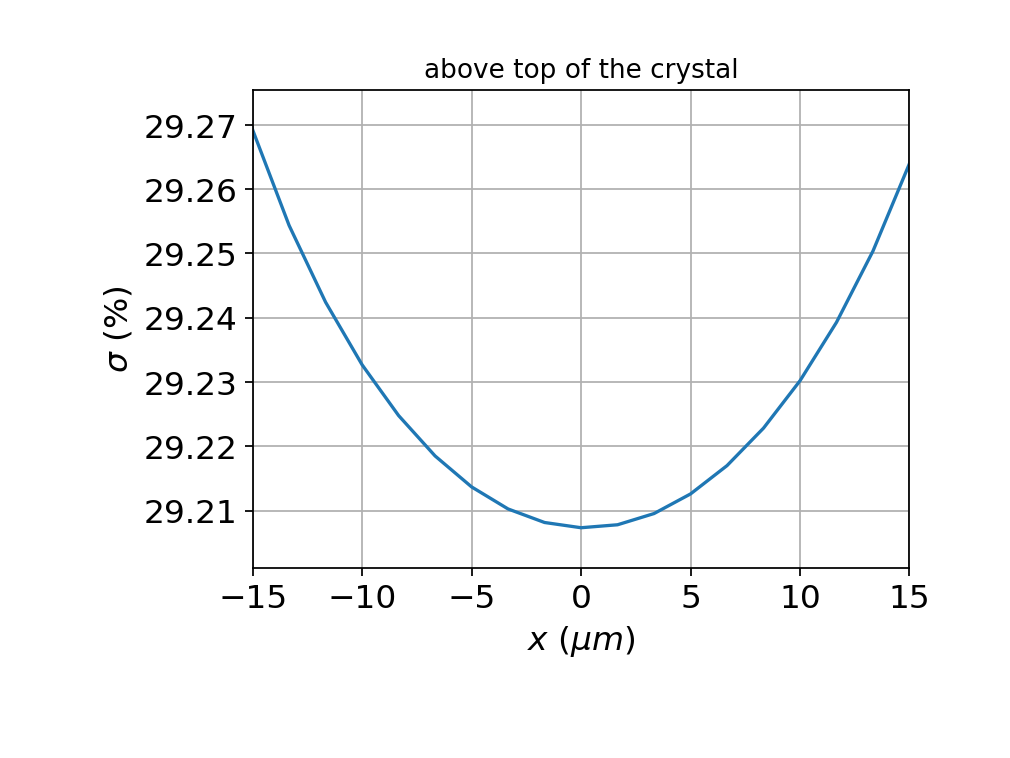

c_r(%) = 0.6097462658123537


<IPython.core.display.Javascript object>


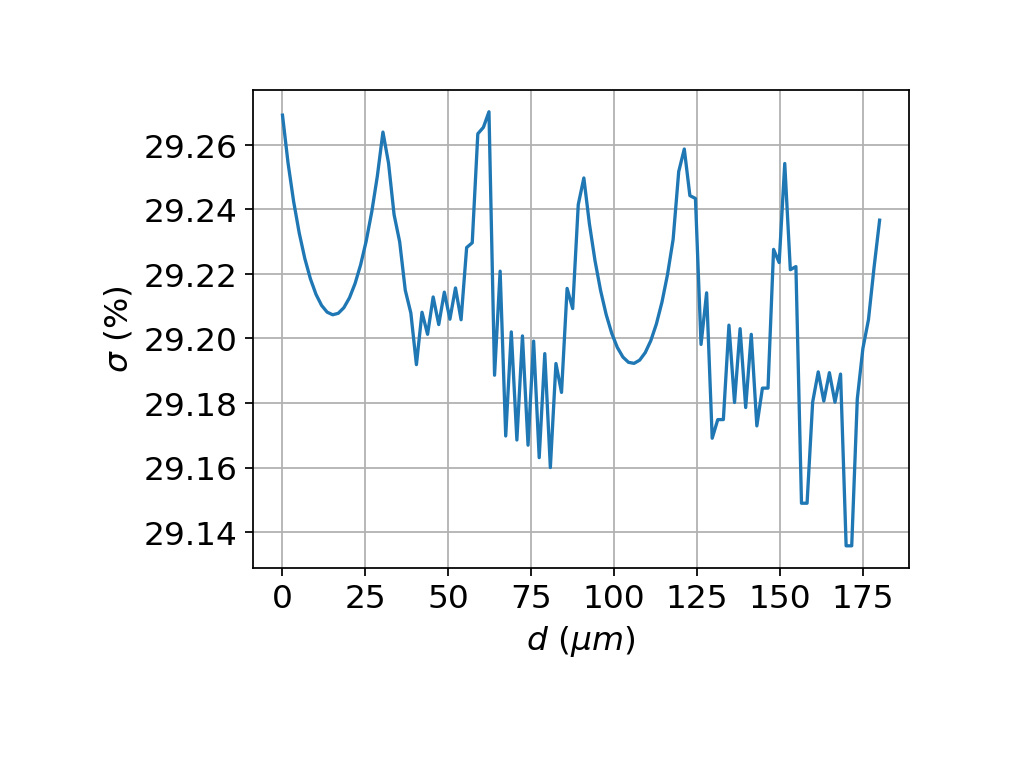

<IPython.core.display.Javascript object>


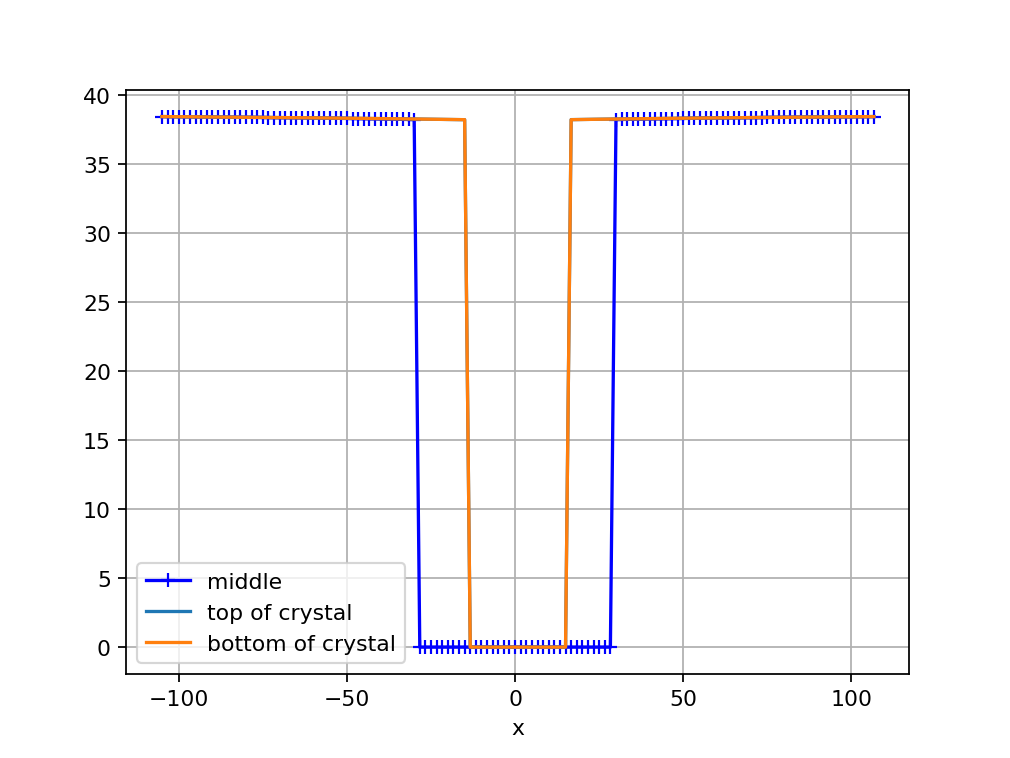

In [15]:
# Specifying larger fonts, etc.
fontsize = 15
margin = 0.25

# Select some points to help with contouring and slicing
ixmid = VFD.Cartesian_position_to_index(0,Lbox_x,dedge); print(ixmid)
iymid = VFD.Cartesian_position_to_index(0,Lbox_y,dedge); print(iymid)
iyabove = VFD.Cartesian_position_to_index(y0,Lbox_y,dedge); print(iyabove)
iybelow = VFD.Cartesian_position_to_index(-y0,Lbox_y,dedge); print(iybelow)

# Graph as contour plot
un1 = un[ixmid,iyabove]
un2 = udirichlet_mag
nlevels = 8
levels = np.linspace(un1,un2,nlevels)
fig,ax = plt.subplots()
ax.set_aspect('equal')
CS = ax.contour(xarray,yarray,un.T,levels)
ax.set_xlabel('$x$ ($\mu m$)', fontsize=fontsize)
ax.set_ylabel('$y$ ($\mu m$)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin)
plt.grid(True)
# fig.colorbar(CS)
plt.plot(edges_again[0,:],edges_again[1,:],'o')

# Horizontal slice that goes across a crystal face
fig,ax = plt.subplots()
sigma_percent = (un[:,iyabove]/P_vapor_eq.magnitude-1)*100
plt.plot(xarray,sigma_percent)
plt.grid(True)
plt.xlim(-L/2,L/2)
VFD.autoscale(ax, 'y')
plt.xlabel('$x$ ($\mu m$)', fontsize=fontsize)
plt.ylabel('$\sigma$ (%)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 
plt.title('above top of the crystal')
c_r_percent = (np.max(un[:,iyabove])-np.min(un[:,iyabove]))/np.max(un[:,iyabove])*100
print('c_r(%) =', c_r_percent)

# Horizontal slice that goes across all the crystal faces
fig,ax = plt.subplots()
sigma_percent = (un[ixedges,iyedges]/P_vapor_eq.magnitude-1)*100
distance_around = np.linspace(0,L*6,npts_total)
plt.plot(distance_around,sigma_percent)
plt.grid(True)
plt.xlabel('$d$ ($\mu m$)', fontsize=fontsize)
plt.ylabel('$\sigma$ (%)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 

# Horizontal slices that go through the crystal to make sure Pvap -> 0 inside
plt.figure()
plt.plot(xarray,un[:,iymid],'b-+',label='middle')
plt.plot(xarray,un[:,iyabove-1],label='top of crystal')
plt.plot(xarray,un[:,iybelow+1],label='bottom of crystal')
plt.grid(True)
plt.xlabel('x')
plt.legend()